In [22]:
# Import Libraries
import pandas as pd
import os
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import pandas as pd
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Analysis on raw news data

In [8]:
# Data folder path
data_folder = "../data/raw/news_data"

# Load and concatenate all CSVs
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".csv")]
df_list = [pd.read_csv(file, encoding='latin1', on_bad_lines='skip') for file in all_files]
df = pd.concat(df_list, ignore_index=True)

# Datetime conversion
df['pub_date'] = pd.to_datetime(df['pub_date'])

# Combine headline + snippet for sentiment analysis
df['text'] = df['headline'].fillna('') + ". " + df['snippet'].fillna('')

# Apply TextBlob sentiment
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Classify sentiment type
def get_sentiment_label(p):
    if p > 0.1:
        return 'Positive'
    elif p < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['polarity'].apply(get_sentiment_label)

# Extract year & quarter
df['year'] = df['pub_date'].dt.year
df['quarter'] = df['pub_date'].dt.to_period('Q')

/var/folders/1w/nn1xvcg955705jzhk3_8w4nr0000gn/T/ipykernel_40690/3440723796.py:32: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['quarter'] = df['pub_date'].dt.to_period('Q')


#### Visualizations for raw news data

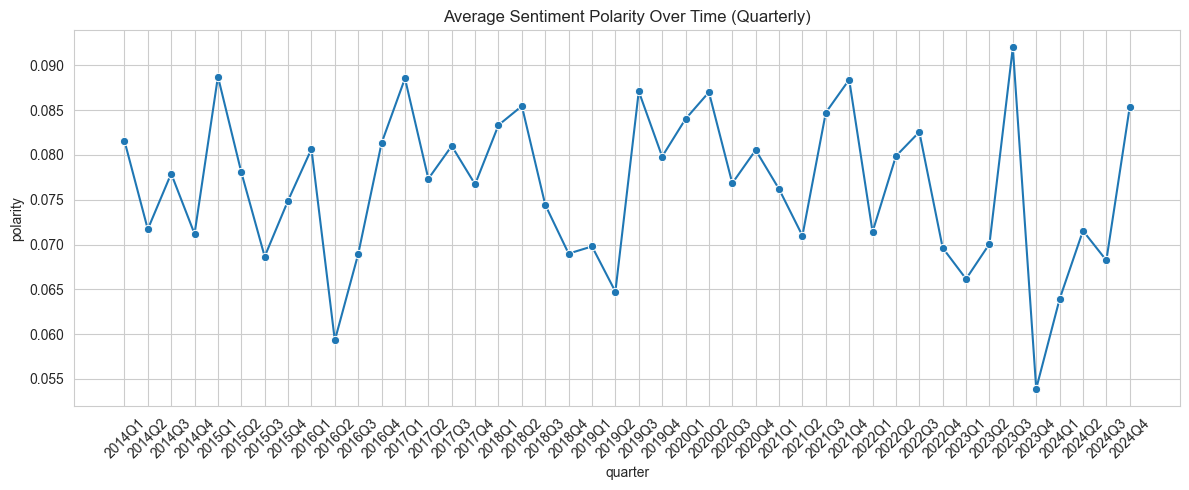

In [9]:
# 1. Average sentiment by quarter
sentiment_by_quarter = df.groupby('quarter')['polarity'].mean().reset_index()
sentiment_by_quarter['quarter'] = sentiment_by_quarter['quarter'].astype(str) 

plt.figure(figsize=(12, 5))
sns.lineplot(data=sentiment_by_quarter, x='quarter', y='polarity', marker='o')
plt.title('Average Sentiment Polarity Over Time (Quarterly)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

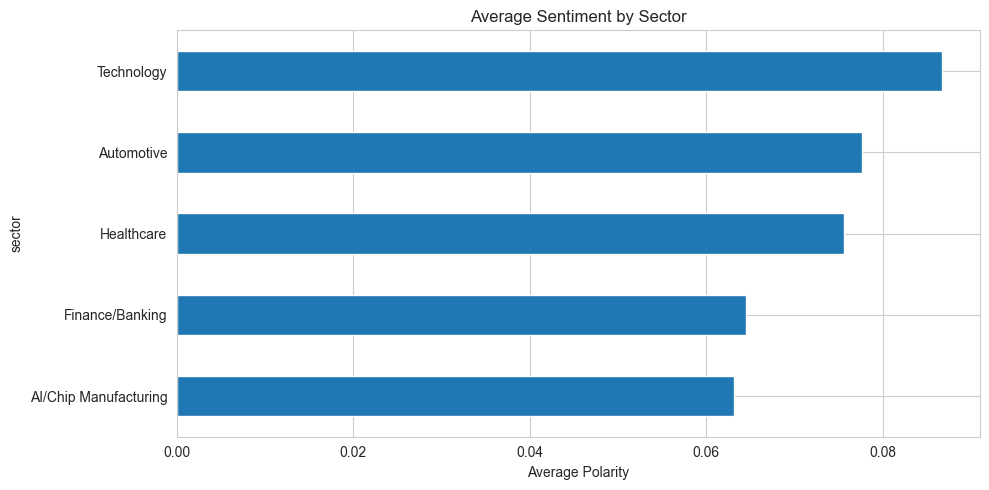

In [10]:
# 2. Sentiment by sector
sector_sentiment = df.groupby(['sector'])['polarity'].mean().sort_values()

plt.figure(figsize=(10, 5))
sector_sentiment.plot(kind='barh')
plt.title('Average Sentiment by Sector')
plt.xlabel('Average Polarity')
plt.tight_layout()
plt.show()

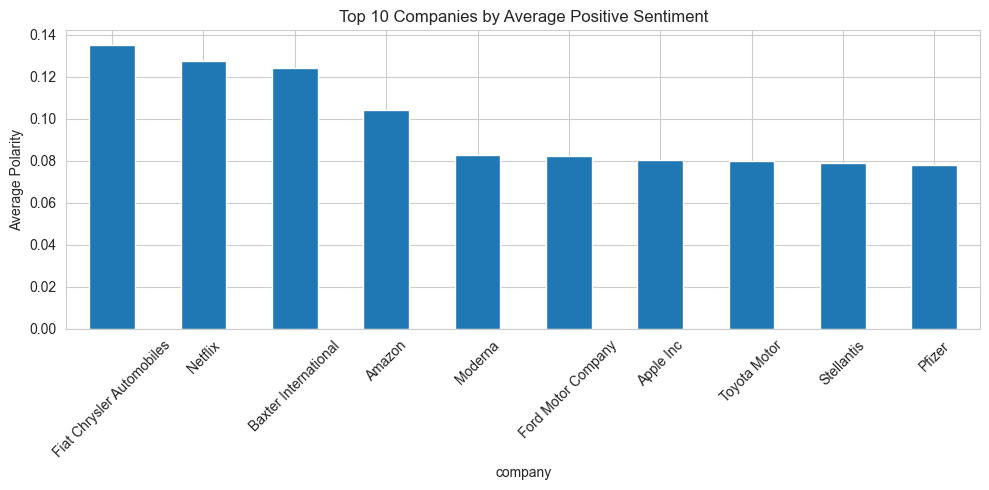

In [11]:
# 3. Sentiment by company
company_sentiment = df.groupby(['company'])['polarity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
company_sentiment.plot(kind='bar')
plt.title('Top 10 Companies by Average Positive Sentiment')
plt.ylabel('Average Polarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

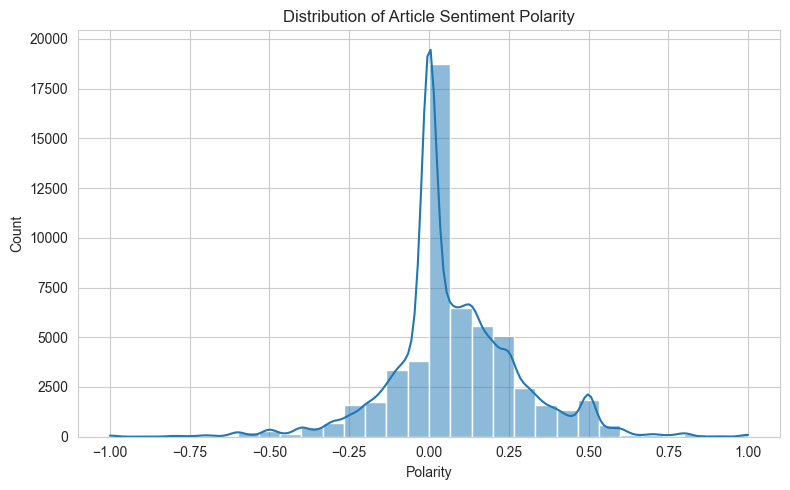

In [12]:
# 4. Sentiment distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['polarity'], kde=True, bins=30)
plt.title('Distribution of Article Sentiment Polarity')
plt.xlabel('Polarity')
plt.tight_layout()
plt.show()

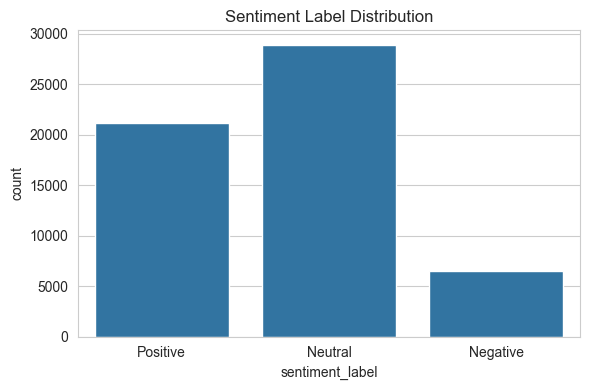

In [13]:
# 5. Count of sentiment labels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment_label')
plt.title('Sentiment Label Distribution')
plt.tight_layout()
plt.show()

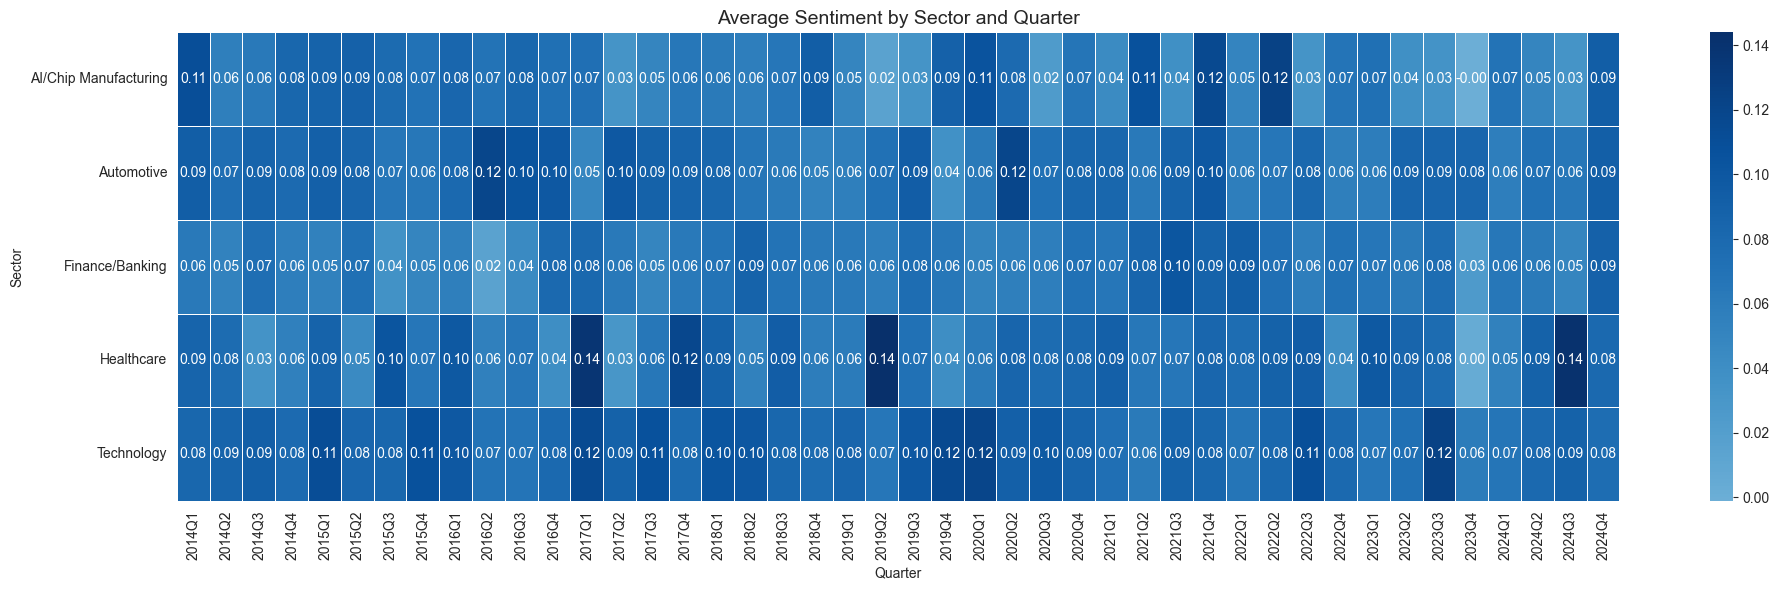

In [14]:
# 6. Average polarity by sector and quarter
heatmap_df = df.groupby(['sector', 'quarter'])['polarity'].mean().unstack().fillna(0)

# Convert column Periods to strings
heatmap_df.columns = heatmap_df.columns.astype(str)

plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_df,center=0, annot=True, fmt=".2f", linewidths=.5, cmap='Blues')
plt.title('Average Sentiment by Sector and Quarter', fontsize=14)
plt.ylabel('Sector')
plt.xlabel('Quarter')
plt.tight_layout()
plt.show()

#### Sentiment comparison with TextBlob, Vader and Finbert

In [18]:
# Comparing with sentiments of one of the quarter news (2024 Q4)
df = pd.read_csv('../data/raw/news_data/nyt_articles_2024_Q4.csv', encoding='ISO-8859-1')
df.head()

,company,sector,headline,snippet,pub_date,url,quarter
0,Ford Motor Company,Automotive,Ford Took an Early Lead in Electric Vehicles. ...,Ford is struggling to make money on battery-po...,2024-10-29T15:49:49+0000,https://www.nytimes.com/2024/10/29/business/fo...,2024-10-01 to 2024-12-31
1,Ford Motor Company,Automotive,Ford Fined Up to $165 Million by Safety Agency...,The regulator faulted the automaker for not re...,2024-11-14T17:29:40+0000,https://www.nytimes.com/2024/11/14/business/ec...,2024-10-01 to 2024-12-31
2,Ford Motor Company,Automotive,"Ford to Cut 4,000 Jobs in Europe as Electric V...",The American automaker said the cost-cutting m...,2024-11-20T16:09:36+0000,https://www.nytimes.com/2024/11/20/business/fo...,2024-10-01 to 2024-12-31
3,Ford Motor Company,Automotive,"Dreamtroit, a Low-Cost Bohemia for Artists, Re...",The former Lincoln Motor factory is in the van...,2024-10-12T09:00:57+0000,https://www.nytimes.com/2024/10/12/arts/design...,2024-10-01 to 2024-12-31
4,Ford Motor Company,Automotive,"In Detroit, Creating a New Hub for Innovation",Entrepreneurs once flocked to Motor City to bu...,2024-10-12T09:01:12+0000,https://www.nytimes.com/2024/10/12/business/sm...,2024-10-01 to 2024-12-31


In [21]:
# Summary statistics 
# Basic Info
print("Shape of data:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Summary Statistics
summary = df.describe()
print("\nSummary statistics:\n", summary)

df_cleaned = df.dropna()
df_cleaned

Shape of data: (1321, 7)

Data Types:
 company     object
sector      object
headline    object
snippet     object
pub_date    object
url         object
quarter     object
dtype: object

Missing values:
 company     0
sector      0
headline    0
snippet     1
pub_date    0
url         0
quarter     0
dtype: int64

Summary statistics:
         company      sector                               headline  \
count      1321        1321                                   1321   
unique       25           5                                    917   
top     Netflix  Technology  Corporate America Hedges on Trump 2.0   
freq        100         470                                      8   

                                                  snippet  \
count                                                1320   
unique                                                917   
top     The race for the White House is deadlocked, bu...   
freq                                                    8   

      

,company,sector,headline,snippet,pub_date,url,quarter
0,Ford Motor Company,Automotive,Ford Took an Early Lead in Electric Vehicles. ...,Ford is struggling to make money on battery-po...,2024-10-29T15:49:49+0000,https://www.nytimes.com/2024/10/29/business/fo...,2024-10-01 to 2024-12-31
1,Ford Motor Company,Automotive,Ford Fined Up to $165 Million by Safety Agency...,The regulator faulted the automaker for not re...,2024-11-14T17:29:40+0000,https://www.nytimes.com/2024/11/14/business/ec...,2024-10-01 to 2024-12-31
2,Ford Motor Company,Automotive,"Ford to Cut 4,000 Jobs in Europe as Electric V...",The American automaker said the cost-cutting m...,2024-11-20T16:09:36+0000,https://www.nytimes.com/2024/11/20/business/fo...,2024-10-01 to 2024-12-31
3,Ford Motor Company,Automotive,"Dreamtroit, a Low-Cost Bohemia for Artists, Re...",The former Lincoln Motor factory is in the van...,2024-10-12T09:00:57+0000,https://www.nytimes.com/2024/10/12/arts/design...,2024-10-01 to 2024-12-31
4,Ford Motor Company,Automotive,"In Detroit, Creating a New Hub for Innovation",Entrepreneurs once flocked to Motor City to bu...,2024-10-12T09:01:12+0000,https://www.nytimes.com/2024/10/12/business/sm...,2024-10-01 to 2024-12-31
...,...,...,...,...,...,...,...
1316,Merck,Healthcare,Jimmy Carterâs Quiet but Monumental Work in ...,"In his decades as a former president, he and h...",2024-12-30T10:00:17+0000,https://www.nytimes.com/2024/12/30/health/jimm...,2024-10-01 to 2024-12-31
1317,Merck,Healthcare,Robert F. Kennedy Jr. Wants to Ban Drug Ads on...,Attempts to restrict pharmaceutical advertisem...,2024-12-23T10:00:30+0000,https://www.nytimes.com/2024/12/23/health/rfk-...,2024-10-01 to 2024-12-31
1318,Merck,Healthcare,Victim of Coney Island Subway Immolation Is Id...,"Debrina Kawam of Toms River, N.J., was burned ...",2024-12-31T16:46:49+0000,https://www.nytimes.com/2024/12/31/nyregion/co...,2024-10-01 to 2024-12-31
1319,Merck,Healthcare,The School for First Ladies Is Now in Session,Itâs a highly visible role that usually come...,2024-10-12T09:02:02+0000,https://www.nytimes.com/2024/10/12/style/globa...,2024-10-01 to 2024-12-31


In [23]:
# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Load pre-trained FinBERT model and tokenizer from Hugging Face
finbert_model_name = 'yiyanghkust/finbert-tone'
tokenizer = BertTokenizer.from_pretrained(finbert_model_name)
model = BertForSequenceClassification.from_pretrained(finbert_model_name)

# Load the pipeline for sentiment-analysis
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Define preprocessing function
def preprocess_text(text):
    if isinstance(text, float):  # Check if text is NaN (float)
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Assuming you already have a dataframe (df) with your data
df['clean_snippet'] = df['snippet'].apply(preprocess_text)

# TextBlob Sentiment Analysis
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df[['textblob_polarity', 'textblob_subjectivity']] = df['clean_snippet'].apply(lambda x: pd.Series(get_textblob_sentiment(x)))

# VADER Sentiment Analysis
def get_vader_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound'], sentiment_scores['pos'], sentiment_scores['neu'], sentiment_scores['neg']

df[['vader_compound', 'vader_pos', 'vader_neu', 'vader_neg']] = df['clean_snippet'].apply(lambda x: pd.Series(get_vader_sentiment(x)))

# FinBERT Sentiment Analysis
def get_finbert_sentiment(text):
    sentiment = finbert(text)
    return sentiment[0]['label'], sentiment[0]['score']

# Apply FinBERT sentiment analysis and create new columns
df[['finbert_label', 'finbert_score']] = df['clean_snippet'].apply(lambda x: pd.Series(get_finbert_sentiment(x)))

# Display the results with sector-wise sentiment analysis
print(df[['sector', 'snippet', 'textblob_polarity', 'vader_compound', 'finbert_label', 'finbert_score']])



Device set to use mps:0


          sector                                            snippet  \
0     Automotive  Ford is struggling to make money on battery-po...   
1     Automotive  The regulator faulted the automaker for not re...   
2     Automotive  The American automaker said the cost-cutting m...   
3     Automotive  The former Lincoln Motor factory is in the van...   
4     Automotive  Entrepreneurs once flocked to Motor City to bu...   
...          ...                                                ...   
1316  Healthcare  In his decades as a former president, he and h...   
1317  Healthcare  Attempts to restrict pharmaceutical advertisem...   
1318  Healthcare  Debrina Kawam of Toms River, N.J., was burned ...   
1319  Healthcare  Itâs a highly visible role that usually come...   
1320  Healthcare  The music mogulâs business portfolio has shr...   

      textblob_polarity  vader_compound finbert_label  finbert_score  
0              0.083333         -0.4215      Negative       0.999999  
1    

In [25]:
# Aggregating the sentiment scores by sector
sector_wise_sentiment = df.groupby('sector').agg(
    textblob_polarity=('textblob_polarity', 'mean'),
    textblob_subjectivity=('textblob_subjectivity', 'mean'),
    vader_compound=('vader_compound', 'mean'),
    vader_pos=('vader_pos', 'mean'),
    vader_neu=('vader_neu', 'mean'),
    vader_neg=('vader_neg', 'mean'),
    finbert_label=('finbert_label', 'first'),  # just take the first value for simplicity
    finbert_score=('finbert_score', 'mean')
).reset_index()

# Displaying the sector-wise sentiment aggregation
sector_wise_sentiment

,sector,textblob_polarity,textblob_subjectivity,vader_compound,vader_pos,vader_neu,vader_neg,finbert_label,finbert_score
0,AI/Chip Manufacturing,0.084934,0.380003,0.057609,0.091718,0.838885,0.069397,Negative,0.929979
1,Automotive,0.070827,0.334215,0.035739,0.083012,0.843073,0.073954,Negative,0.944261
2,Finance/Banking,0.090151,0.360929,0.085128,0.092490,0.841784,0.065729,Negative,0.938212
3,Healthcare,0.057185,0.368531,-0.015266,0.075552,0.848793,0.075586,Positive,0.950344
4,Technology,0.067390,0.354499,0.108766,0.102494,0.827794,0.067572,Positive,0.956131


In [ ]:
# Initialize the VADER SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Initialize the FinBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Function to analyze sentiment using VADER
def get_vader_sentiment(text):
    if isinstance(text, str):  # Ensure the text is a string
        sentiment_score = vader_analyzer.polarity_scores(text)
        return sentiment_score['compound']
    return 0  # Return 0 if it's not a valid string

# Function to analyze sentiment using FinBERT
def get_finbert_sentiment(text):
    if isinstance(text, str):  # Ensure the text is a string
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        sentiment = torch.argmax(outputs.logits).item()
        return sentiment  # 0 = Negative, 1 = Neutral, 2 = Positive
    return 1  # Neutral sentiment if it's not a valid string

# Function to analyze sentiment using TextBlob
def get_textblob_sentiment(text):
    if isinstance(text, str):  # Ensure the text is a string
        blob = TextBlob(text)
        return blob.sentiment.polarity  # -1 (negative) to +1 (positive)
    return 0  # Neutral sentiment if it's not a valid string

# Fill missing values in 'snippet' with an empty string or drop rows with missing values
df['snippet'] = df['snippet'].fillna('')

# Apply sentiment analysis on SNIPPET instead of headline
df['vader_sentiment'] = df['snippet'].apply(get_vader_sentiment)
df['finbert_sentiment'] = df['snippet'].apply(get_finbert_sentiment)
df['textblob_sentiment'] = df['snippet'].apply(get_textblob_sentiment)

# Function to analyze sentiment sector-wise
def analyze_sector_sentiment(df, sector):
    sector_df = df[df['sector'] == sector]
    vader_avg_sentiment = sector_df['vader_sentiment'].mean()
    finbert_avg_sentiment = sector_df['finbert_sentiment'].mean()
    textblob_avg_sentiment = sector_df['textblob_sentiment'].mean()
    return vader_avg_sentiment, finbert_avg_sentiment, textblob_avg_sentiment

# Create a list of sectors
sectors = df['sector'].unique()

# Dictionary to hold sentiment scores per sector
sector_sentiment = {}

# Analyze sentiment for each sector
for sector in sectors:
    vader_sentiment, finbert_sentiment, textblob_sentiment = analyze_sector_sentiment(df, sector)
    sector_sentiment[sector] = {
        'VADER Sentiment': vader_sentiment,
        'FinBERT Sentiment': finbert_sentiment,
        'TextBlob Sentiment': textblob_sentiment
    }

# Convert results into a DataFrame
sector_sentiment_df = pd.DataFrame(sector_sentiment).T

print(sector_sentiment_df)

                       VADER Sentiment  FinBERT Sentiment  TextBlob Sentiment
Automotive                    0.039835           0.691131            0.070045
Technology                    0.115720           0.519149            0.065506
Finance/Banking               0.101223           0.715753            0.089791
AI/Chip Manufacturing         0.063451           0.632184            0.081821
Healthcare                   -0.015266           0.500000            0.057185


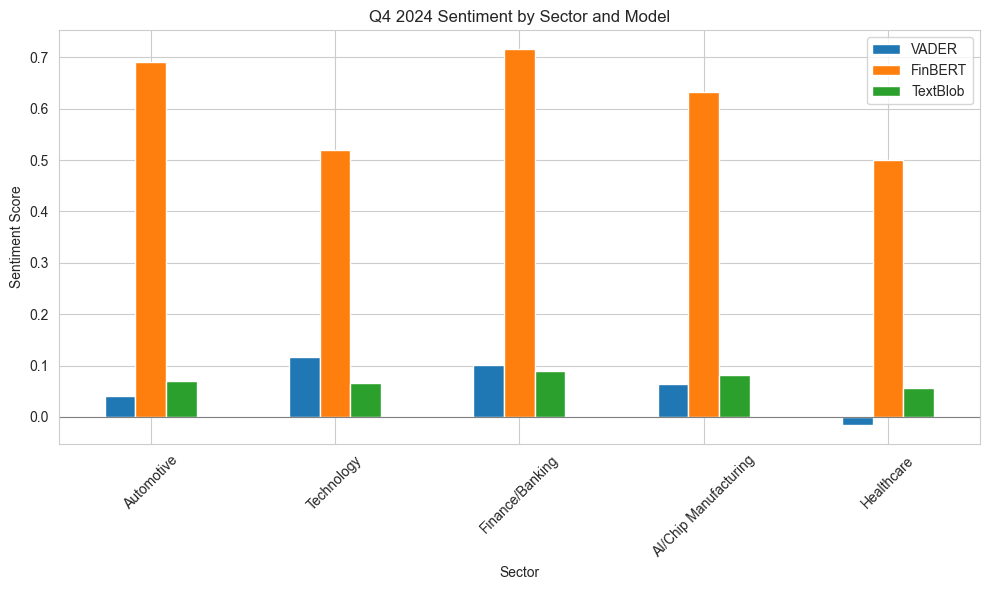

In [38]:
import matplotlib.pyplot as plt

# Create a DataFrame for the Q4 sentiment
q4_df = pd.DataFrame({
    'Sector': ['Automotive', 'Technology', 'Finance/Banking', 'AI/Chip Manufacturing', 'Healthcare'],
    'VADER': [0.039835, 0.115720, 0.101223, 0.063451, -0.015266],
    'FinBERT': [0.691131, 0.519149, 0.715753, 0.632184, 0.5],
    'TextBlob': [0.070045, 0.065506, 0.089791, 0.081821, 0.057185]
})

q4_df.set_index('Sector').plot(kind='bar', figsize=(10, 6))
plt.title("Q4 2024 Sentiment by Sector and Model")
plt.ylabel("Sentiment Score")
plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


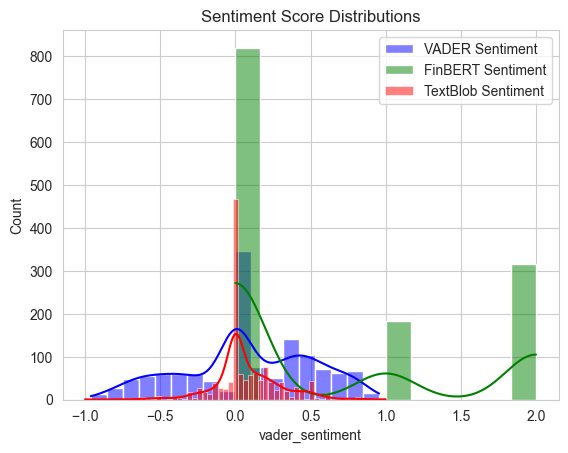

In [29]:

# Plot distributions for VADER, FinBERT, and TextBlob sentiment scores
sns.histplot(df['vader_sentiment'], color='blue', kde=True, label='VADER Sentiment')
sns.histplot(df['finbert_sentiment'], color='green', kde=True, label='FinBERT Sentiment')
sns.histplot(df['textblob_sentiment'], color='red', kde=True, label='TextBlob Sentiment')
plt.legend()
plt.title('Sentiment Score Distributions')
plt.show()

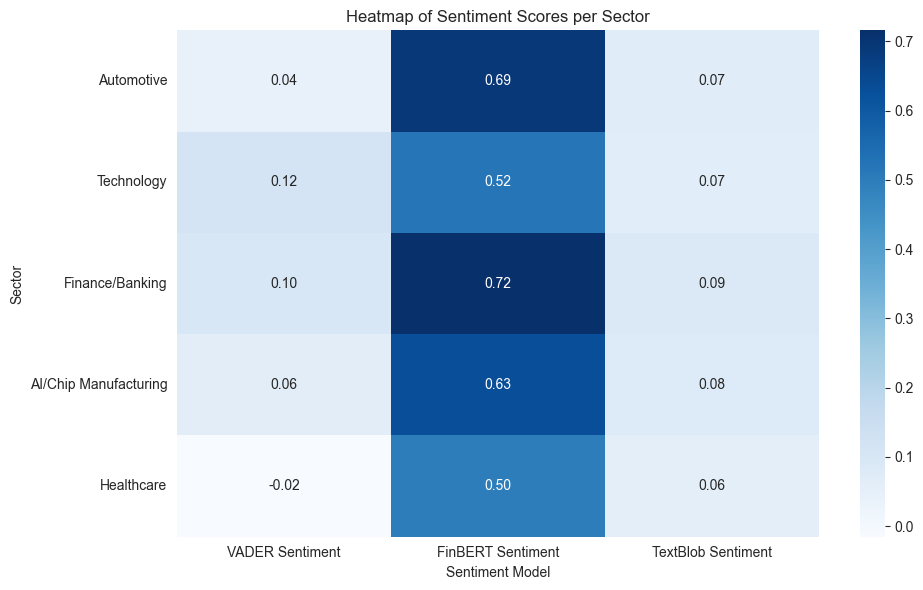

In [31]:
# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sector_sentiment_df, annot=True, cmap='Blues', cbar=True, fmt='.2f')
plt.title('Heatmap of Sentiment Scores per Sector')
plt.xlabel('Sentiment Model')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()

#### Visualizations on final weighted sentiment data

In [50]:
# Load dataset
df = pd.read_csv('../data/processed/sector_sentiment_with_metrics_quarterly_2014_2024.csv')
df

,Date,weighted_sentiment_AI/Chip Manufacturing,weighted_sentiment_Automotive,weighted_sentiment_Finance/Banking,weighted_sentiment_Healthcare,weighted_sentiment_Technology,avg_relative_sentiment_AI/Chip Manufacturing,avg_relative_sentiment_Automotive,avg_relative_sentiment_Finance/Banking,avg_relative_sentiment_Healthcare,...,sentiment_dispersion_AI/Chip Manufacturing,sentiment_dispersion_Automotive,sentiment_dispersion_Finance/Banking,sentiment_dispersion_Healthcare,sentiment_dispersion_Technology,avg_normalized_sentiment_AI/Chip Manufacturing,avg_normalized_sentiment_Automotive,avg_normalized_sentiment_Finance/Banking,avg_normalized_sentiment_Healthcare,avg_normalized_sentiment_Technology
0,3/31/14,2.5346,74.7350,69.8162,0.6884,85.5526,0.0316,0.0817,-0.0353,-0.0805,...,0.7367,0.7636,0.6794,0.7189,0.7019,0.2901,0.3152,0.2566,0.2340,0.2570
1,6/30/14,3.7788,65.5828,52.7604,6.8142,84.3869,0.0833,0.1326,-0.1021,-0.0846,...,0.7454,0.7707,0.6371,0.6652,0.7024,0.3112,0.3359,0.2185,0.2273,0.2670
2,9/30/14,1.7344,34.2622,71.0870,10.4246,82.2011,0.0070,0.0238,0.0212,0.0344,...,0.8044,0.7370,0.7274,0.7990,0.6671,0.2681,0.2765,0.2752,0.2818,0.2420
3,12/31/14,2.5832,27.3082,82.1093,3.5456,83.4074,-0.0312,0.0551,0.0477,-0.0151,...,0.6902,0.7123,0.7244,0.6297,0.6325,0.2471,0.2902,0.2865,0.2551,0.2315
4,3/31/15,1.4318,28.0000,27.0202,1.0732,43.5732,-0.0859,0.0909,0.0603,-0.1347,...,0.6451,0.6629,0.7319,0.4624,0.5816,0.1944,0.2828,0.2675,0.1700,0.2052
5,6/30/15,0.8030,27.5312,39.2643,1.6185,29.6259,-0.1607,0.1339,0.1051,-0.0922,...,0.4928,0.7221,0.7382,0.6765,0.5326,0.1522,0.2995,0.2851,0.1864,0.1630
6,9/30/15,1.9068,46.1972,28.2124,3.9534,41.5536,0.0574,0.1064,0.0286,-0.0637,...,0.8270,0.7216,0.7148,0.6582,0.6054,0.2909,0.3154,0.2765,0.2303,0.2103
7,12/31/15,2.0908,38.2038,40.5913,4.5164,40.5491,0.1171,0.0277,0.0875,-0.0210,...,0.8960,0.7341,0.7683,0.6450,0.6369,0.3273,0.2826,0.3125,0.2582,0.2133
8,3/31/16,1.2537,23.6921,95.4328,2.3983,85.2317,-0.0673,0.1386,0.0776,0.0471,...,0.6667,0.7747,0.8329,0.8147,0.6441,0.2456,0.3486,0.3181,0.3028,0.2170
9,6/30/16,1.8744,25.4380,84.1539,3.1631,87.2894,-0.0196,0.1014,0.0426,0.0806,...,0.8347,0.7490,0.7409,0.8390,0.6294,0.2647,0.3252,0.2958,0.3148,0.2280


In [51]:
# Summary statistics 
# Basic Info
print("Shape of data:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Summary Statistics
summary = df.describe().T
summary

Shape of data: (44, 26)

Data Types:
 Date                                               object
weighted_sentiment_AI/Chip Manufacturing          float64
weighted_sentiment_Automotive                     float64
weighted_sentiment_Finance/Banking                float64
weighted_sentiment_Healthcare                     float64
weighted_sentiment_Technology                     float64
avg_relative_sentiment_AI/Chip Manufacturing      float64
avg_relative_sentiment_Automotive                 float64
avg_relative_sentiment_Finance/Banking            float64
avg_relative_sentiment_Healthcare                 float64
avg_relative_sentiment_Technology                 float64
avg_momentum_AI/Chip Manufacturing                float64
avg_momentum_Automotive                           float64
avg_momentum_Finance/Banking                      float64
avg_momentum_Healthcare                           float64
avg_momentum_Technology                           float64
sentiment_dispersion_AI/Chip Manuf

,count,mean,std,min,25%,50%,75%,max
weighted_sentiment_AI/Chip Manufacturing,44.0,4.395898,4.800531,0.5307,1.626625,2.55890,4.626625,25.5436
weighted_sentiment_Automotive,44.0,41.378393,17.155097,11.8660,32.967175,39.22085,46.437475,97.2097
weighted_sentiment_Finance/Banking,44.0,59.254575,19.371660,27.0202,47.701625,57.59920,67.928750,113.9126
weighted_sentiment_Healthcare,44.0,8.544350,14.626709,0.4329,0.954825,1.85400,5.090850,54.4383
weighted_sentiment_Technology,44.0,95.037466,23.412699,29.6259,85.110225,95.76030,110.082425,140.0336
avg_relative_sentiment_AI/Chip Manufacturing,44.0,0.029477,0.122723,-0.3079,-0.036200,0.02035,0.107425,0.2937
avg_relative_sentiment_Automotive,44.0,0.070425,0.061981,-0.0912,0.025975,0.07205,0.110025,0.2034
avg_relative_sentiment_Finance/Banking,44.0,0.061232,0.079240,-0.1021,0.000175,0.06225,0.120000,0.2286
avg_relative_sentiment_Healthcare,44.0,-0.045620,0.110666,-0.4247,-0.095600,-0.03975,0.023450,0.1985
avg_relative_sentiment_Technology,44.0,-0.077080,0.051903,-0.1829,-0.113800,-0.07890,-0.040950,0.0288


In [52]:
# Convert 'quarter' to datetime-like format
df['Date'] = df['Date'].astype(str)

# Extract sector names
sectors = ['AI/Chip Manufacturing', 'Automotive', 'Finance/Banking', 'Healthcare', 'Technology']

# Set a consistent style
sns.set_style("whitegrid")

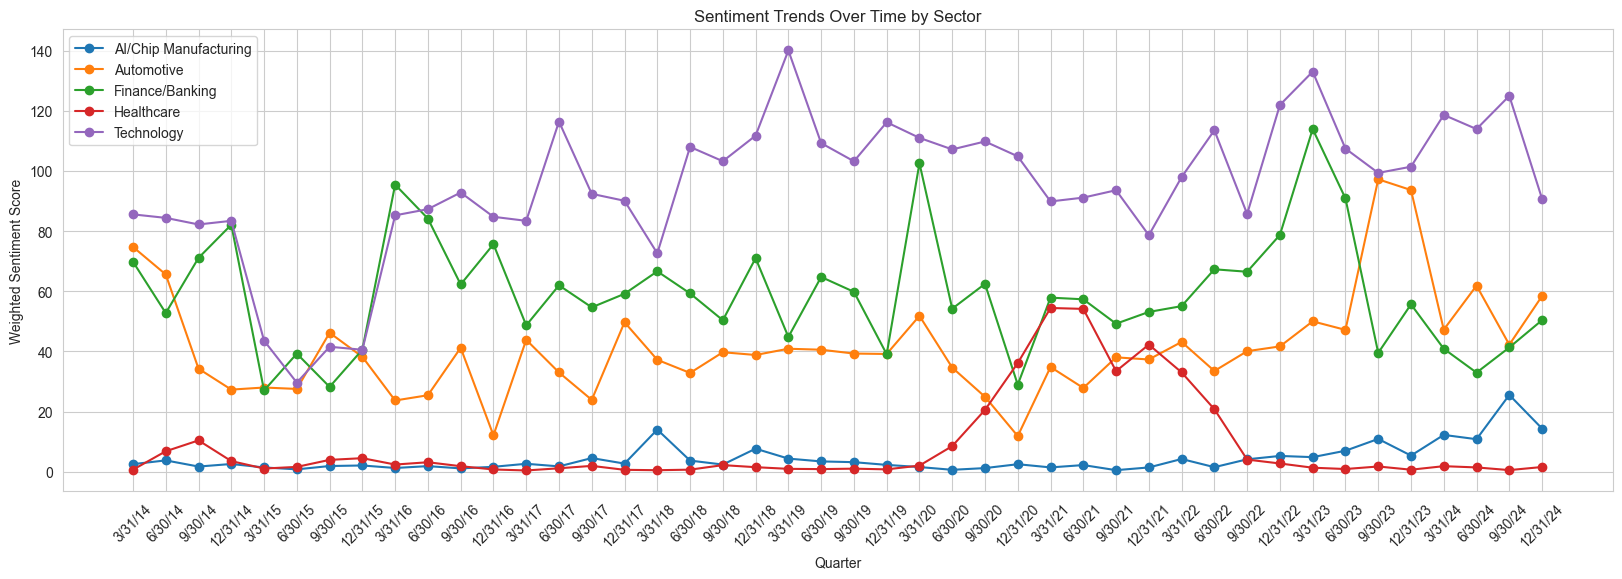

In [ ]:
# Time Series Line Chart 
plt.figure(figsize=(20, 6))
for sector in sectors:
    plt.plot(df['Date'], df[f'weighted_sentiment_{sector}'], label=sector, marker='o')
plt.xlabel("Quarter")
plt.ylabel("Weighted Sentiment Score")
plt.title("Sentiment Trends Over Time by Sector")
plt.legend()
plt.xticks(rotation=45)
plt.show()

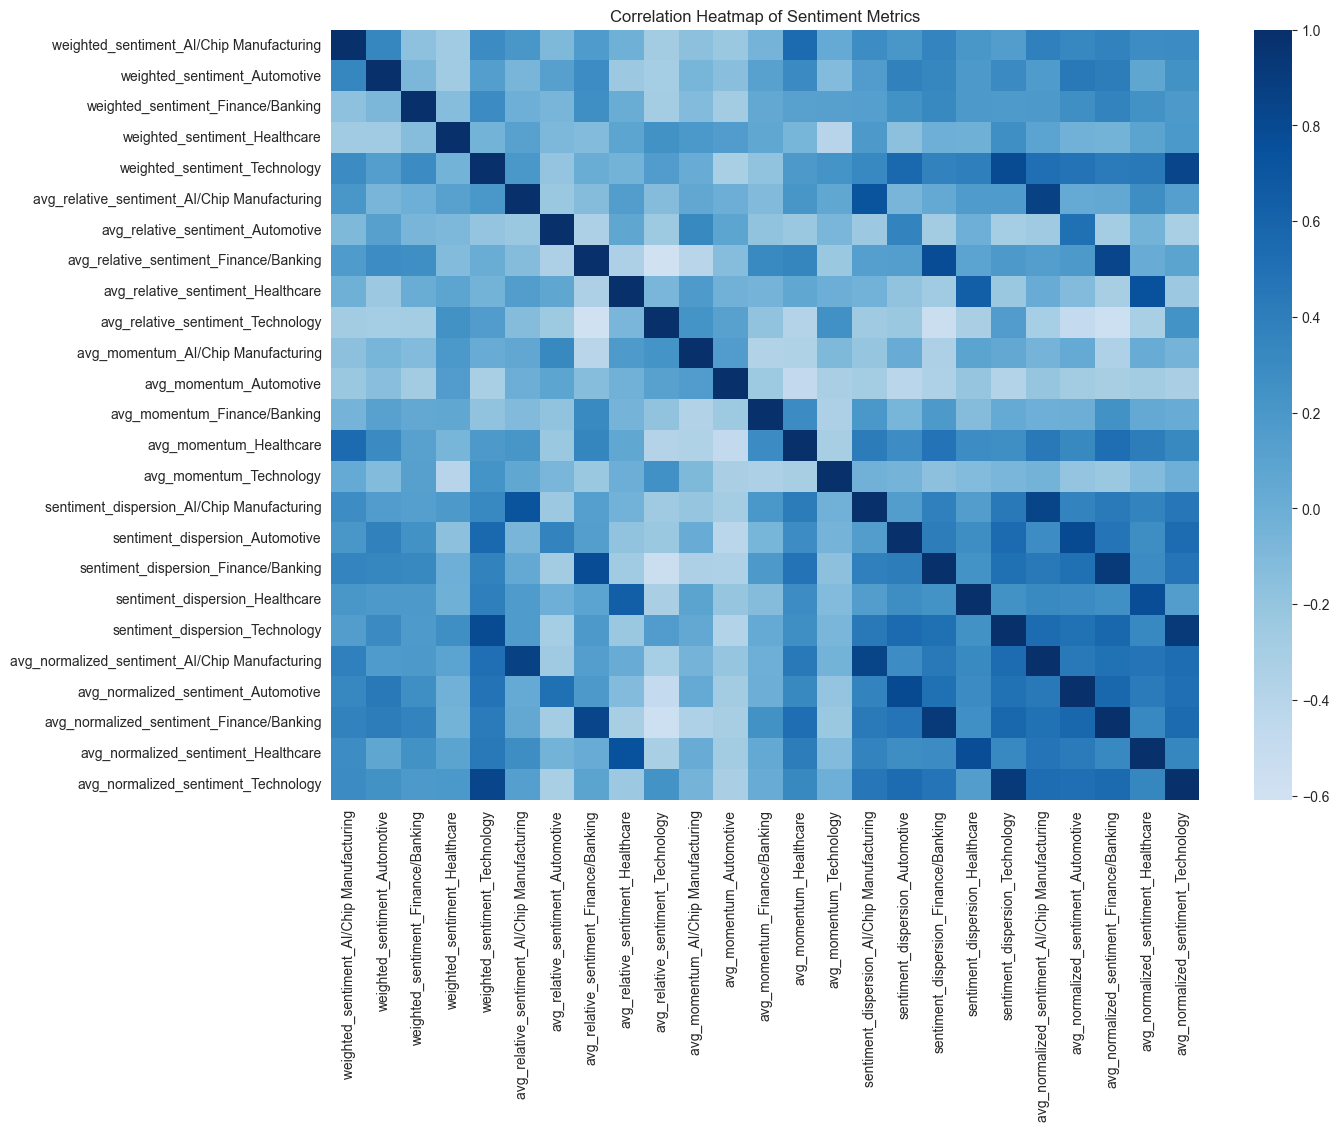

In [55]:
# Correlation Matrix
correlation = df.drop(columns='Date').corr()
plt.figure(figsize=(14,10))
sns.heatmap(correlation, cmap='Blues', center=0, annot=False)
plt.title("Correlation Heatmap of Sentiment Metrics")
plt.show()

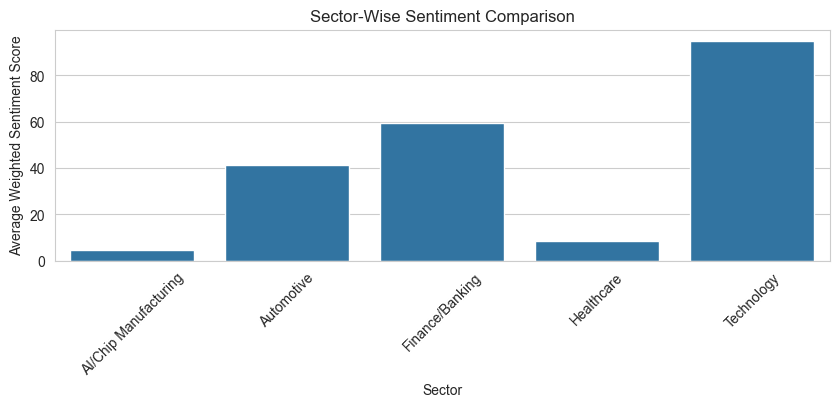

In [59]:
# Bar Chart: Sentiment Comparison Across Sectors ###
plt.figure(figsize=(10, 3))
avg_sentiment = {s: df[f'weighted_sentiment_{s}'].mean() for s in sectors}
sns.barplot(x=list(avg_sentiment.keys()), y=list(avg_sentiment.values()))
plt.xlabel("Sector")
plt.ylabel("Average Weighted Sentiment Score")
plt.title("Sector-Wise Sentiment Comparison")
plt.xticks(rotation=45)
plt.show()

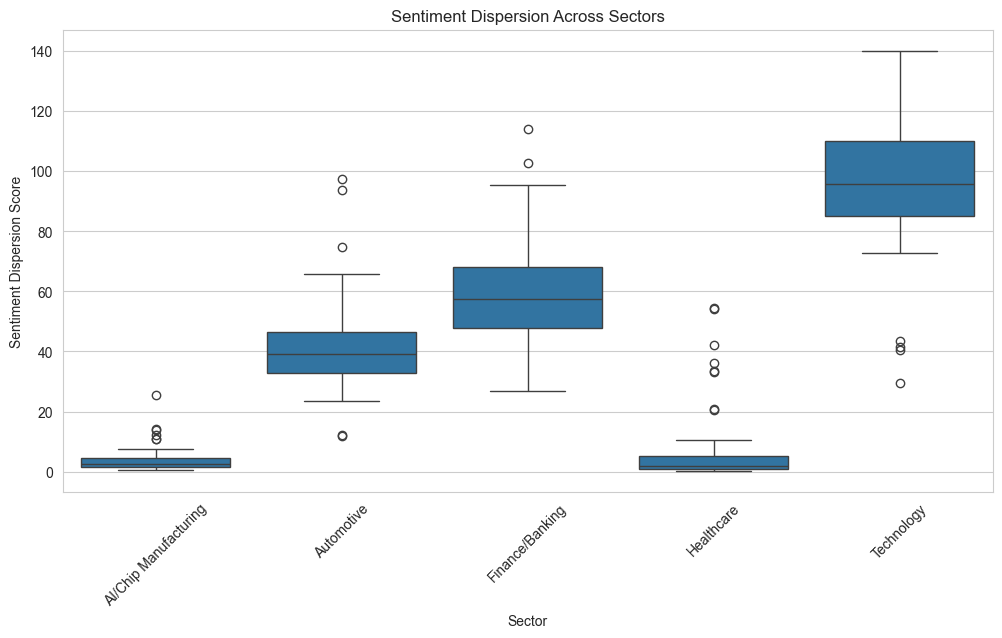

In [60]:
# Boxplot: Sentiment Dispersion Across Sectors
plt.figure(figsize=(12, 6))
sentiment_data = pd.melt(df, id_vars=['Date'], value_vars=[f'weighted_sentiment_{s}' for s in sectors], var_name="Sector", value_name="Sentiment Score")
sentiment_data["Sector"] = sentiment_data["Sector"].str.replace("weighted_sentiment_", "")

sns.boxplot(data=sentiment_data, x="Sector", y="Sentiment Score")
plt.xlabel("Sector")
plt.ylabel("Sentiment Dispersion Score")
plt.title("Sentiment Dispersion Across Sectors")
plt.xticks(rotation=45)
plt.show()

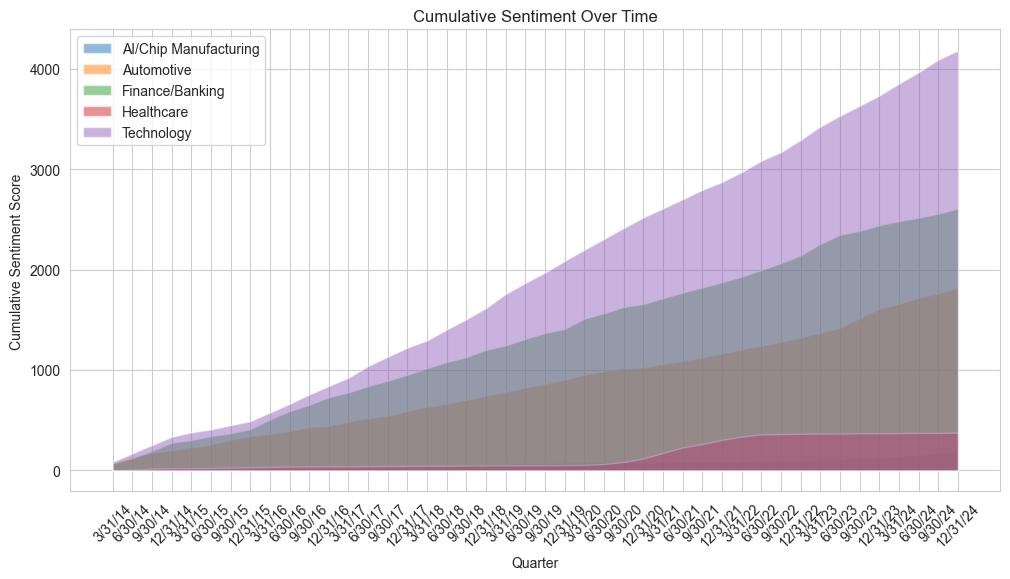

In [62]:
# Area Chart: Cumulative Sentiment
plt.figure(figsize=(12, 6))
for sector in sectors:
    plt.fill_between(df['Date'], df[f'weighted_sentiment_{sector}'].cumsum(), alpha=0.5, label=sector)

plt.xlabel("Quarter")
plt.ylabel("Cumulative Sentiment Score")
plt.title("Cumulative Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

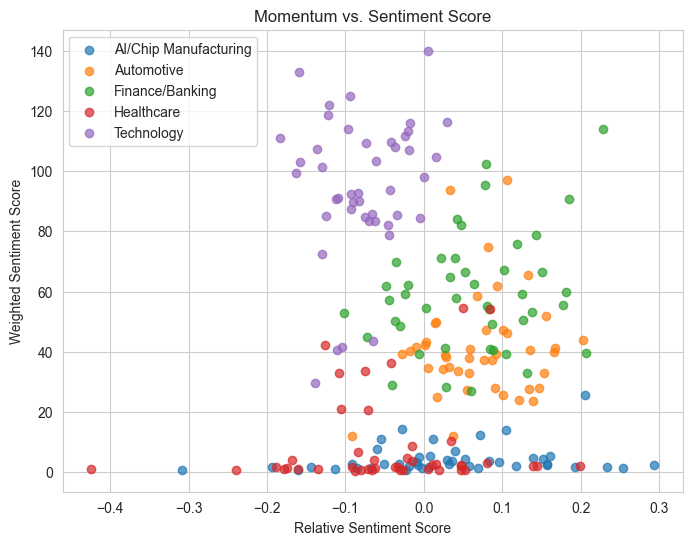

In [63]:
#Scatter Plot: Momentum vs. Sentiment
plt.figure(figsize=(8, 6))
for sector in sectors:
    plt.scatter(df[f'avg_relative_sentiment_{sector}'], df[f'weighted_sentiment_{sector}'], label=sector, alpha=0.7)

plt.xlabel("Relative Sentiment Score")
plt.ylabel("Weighted Sentiment Score")
plt.title("Momentum vs. Sentiment Score")
plt.legend()
plt.show()

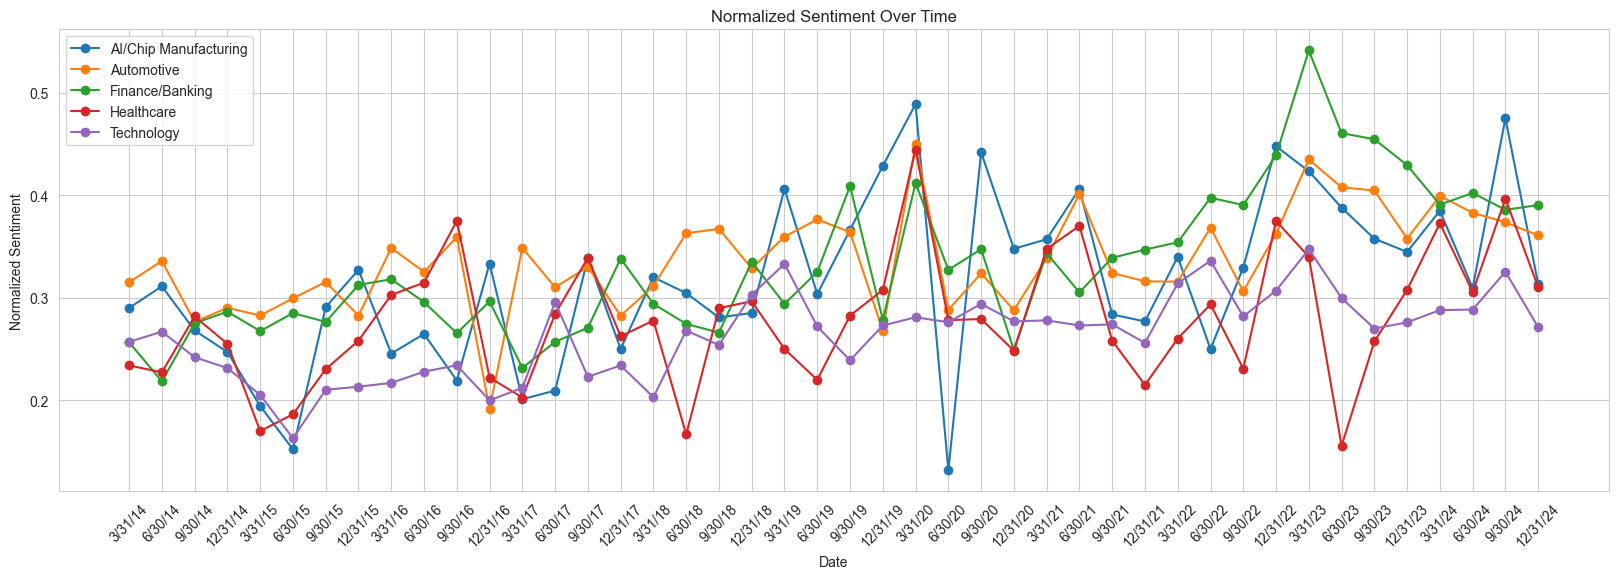

In [ ]:
# Normalized Sentiment Trend
plt.figure(figsize=(20, 6))
for sector in sectors:
    plt.plot(df['Date'], df[f'avg_normalized_sentiment_{sector}'], label=sector, marker='o')
plt.title("Normalized Sentiment Over Time")
plt.ylabel("Normalized Sentiment")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.show()

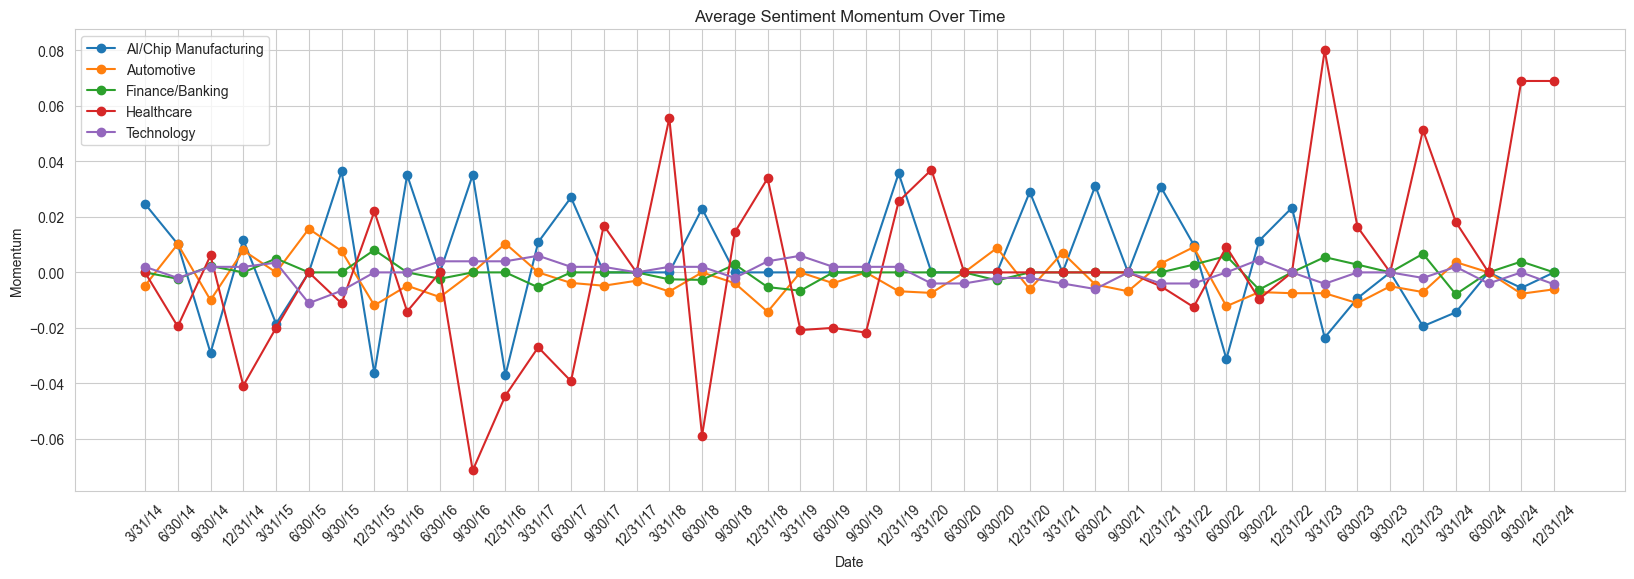

In [82]:
# Momentum over time
plt.figure(figsize=(20, 6))
for sector in sectors:
    plt.plot(df['Date'], df[f'avg_momentum_{sector}'], label=sector, marker='o')
plt.title("Average Sentiment Momentum Over Time")
plt.ylabel("Momentum")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.show()